## Generate Plots for MCMC inference

In [1]:
import random
import time

import tikzplotlib
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro.distributions as npdist
import numpyro
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
import pickle

import jax.config as config
config.update("jax_enable_x64", True)

from priorCVAE.priors import Matern52, SquaredExponential
from experiments.zimbabwe.zimbabwe_utility import read_data

In [20]:
def model_centroids(x, n_obs=None, kernel=Matern52(), y=None):
    
    # fixed effects
    b0 = numpyro.sample('b0', npdist.Normal(0, 1))
     
    lengthscale = numpyro.sample("lengthscale", npdist.Gamma(2,4)) 
    kernel.lengthscale = lengthscale
    k = kernel(x, x)
    
    kernel_var = numpyro.sample("variance", npdist.Gamma(1.5, 1.5)) 
    N = x.shape[0]
    re_std = numpyro.sample('re_std', npdist.MultivariateNormal(loc=jnp.zeros(N), covariance_matrix=k))
    re = numpyro.deterministic('re', kernel_var * re_std)
    
    # linear predictor
    lp = b0 + re
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))
    
    numpyro.sample("obs", npdist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

In [21]:
gp_mcmc_inference_path = "zimbabwe_gp_mcmc.pkl"
data_path = "../data/zwe2016phia.geojson"

In [22]:
with open(gp_mcmc_inference_path, "rb") as input_file:
     gp_mcmc = pickle.load(input_file)

In [23]:
mcmc_gp_samples = gp_mcmc.get_samples()

In [26]:
x, data_centroid = read_data(data_path, normalize=False)
data = gpd.read_file(data_path)

data['y'] = round(data['y']).astype(int)
data['n_obs'] = round(data['n_obs']).astype(int)

/Users/vermap1/projects/PriorCVAE_JAX/experiments/zimbabwe/zimbabwe_utility.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_frame["centroid"] = data_frame["geometry"].centroid
/Users/vermap1/projects/PriorCVAE_JAX/experiments/zimbabwe/zimbabwe_utility.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  temp_centroids = data_frame["geometry"].centroid


In [38]:
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(random.randint(0, 9999)))
gp_predictive = Predictive(model_centroids, num_samples=5000)
gp_preds = gp_predictive(rng_key_, x=x, n_obs = jnp.array(data.n_obs))

ls_prior_draws = gp_preds['lengthscale']
kernel_var_prior = gp_preds['variance']

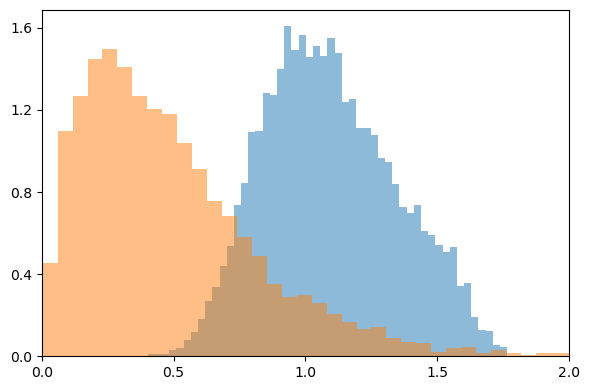

In [45]:
c_samps_gp = mcmc_gp_samples['lengthscale']

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.hist(c_samps_gp, density=True, bins=50, alpha=0.5)
plt.hist(ls_prior_draws, density=True, bins=50, alpha=0.5)

plt.xlim([0, 2.])

plt.xticks([0, 0.5, 1.0, 1.5, 2.0])
plt.yticks([0, 0.4, 0.8, 1.2, 1.6])

plt.tight_layout()

tikzplotlib.save(r"lengthscale.tex",
                 figurewidth='\\figurewidth', figureheight='\\figureheight',
                 figure=fig)

plt.show()

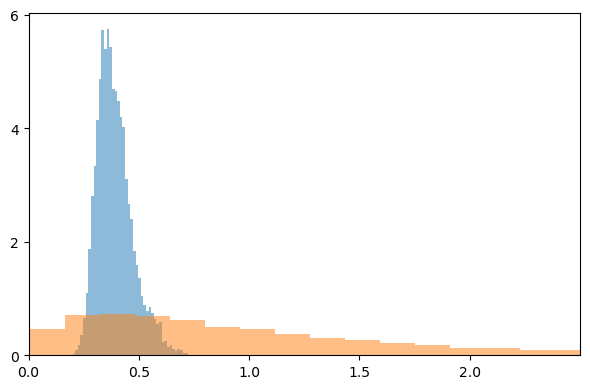

In [46]:
var_samps_gp = mcmc_gp_samples['variance']
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

plt.hist(var_samps_gp, density=True, bins=50, alpha=0.5)
plt.hist(kernel_var_prior, density=True, bins=50, alpha=0.5)

plt.xlim([0, 2.5])
plt.xticks([0, 0.5, 1.0, 1.5, 2.0])
plt.yticks([0, 2, 4, 6])

plt.tight_layout()
tikzplotlib.save(r"variance.tex",
                 figurewidth='\\figurewidth', figureheight='\\figureheight',
                 figure=fig)

plt.show()